In [4]:
# Importing libraries

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [80]:
# Loading data

data = pd.read_csv(r"C:\Users\alex\OneDrive\Desktop\Data\Apples Data Set.csv", header=0, index_col=0)

# Testing 

data.head()

,German Apples (EUR),UK Apples (GBP),EURGBP
01/01/2015,100.000000,119.158676,0.850000
02/01/2015,99.405545,117.280980,0.854055
05/01/2015,99.725345,117.678202,0.850161
06/01/2015,101.793753,121.447448,0.850128
07/01/2015,101.429514,122.719267,0.846781


# Question 1

In [77]:
# Normalising for FX rates

norm_uk = data["UK Apples (GBP)"] / data["EURGBP"]
norm_ger = data["German Apples (EUR)"]
norm_data = pd.DataFrame([norm_ger, norm_uk]).T
norm_data.columns = ["German Apples (EUR)", "UK Apples (EUR)"]

# Testing

norm_data.head()

,German Apples (EUR),UK Apples (EUR)
01/01/2015,100.000000,140.186677
02/01/2015,99.405545,137.322453
05/01/2015,99.725345,138.418792
06/01/2015,101.793753,142.857801
07/01/2015,101.429514,144.924384


# Question 2

alpha=1.689201, const=-41.143099
theta=3.310672, mu=2.570095, sigma=85.737299


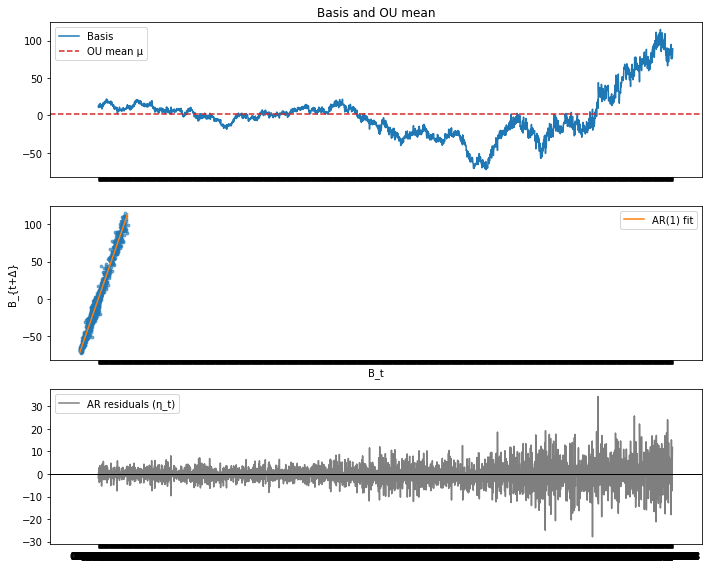

In [72]:
# Measuring and modelling the basis
# Assuming Ornstein-Uhlenbeck (OU) process and small idiosyncratic noise adjustments

norm_ger = sm.add_constant(norm_data["German Apples (EUR)"])
ols = sm.OLS(norm_data["UK Apples (EUR)"], norm_ger, missing="drop").fit()
const, alpha = ols.params["const"], ols.params["German Apples (EUR)"]

norm_data["Basis"] = norm_data["UK Apples (EUR)"] - (const + alpha * norm_data["German Apples (EUR)"])

b = norm_data["Basis"]
ar_normdata = pd.DataFrame({"b_t": b, "b_next": b.shift(-1)}).dropna()

X_ar = sm.add_constant(ar_normdata["b_t"])
ar = sm.OLS(ar_normdata["b_next"], X_ar).fit()
a, c = ar.params["b_t"], ar.params["const"]
sigma_delta_sq = np.var(ar.resid, ddof=1)

delta = 1.0 / 252.0

theta = -np.log(a) / delta
mu = c / (1 - a)
sigma = np.sqrt((2 * theta * sigma_delta_sq) / (1 - a**2))

# Constants

print(f"alpha={alpha:.6f}, const={const:.6f}")
print(f"theta={theta:.6f}, mu={mu:.6f}, sigma={sigma:.6f}")

# Plots

fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

axes[0].plot(norm_data.index, norm_data["Basis"], label="Basis", color="tab:blue")
axes[0].axhline(mu, color="tab:red", linestyle="--", label="OU mean μ")
axes[0].set_title("Basis and OU mean")
axes[0].legend()

xgrid = np.linspace(ar_normdata["b_t"].min(), ar_normdata["b_t"].max(), 200)
axes[1].scatter(ar_normdata["b_t"], ar_normdata["b_next"], s=8, alpha=0.6)
axes[1].plot(xgrid, a * xgrid + c, color="tab:orange", label="AR(1) fit")
axes[1].set_ylabel("B_{t+Δ}")
axes[1].set_xlabel("B_t")
axes[1].legend()

axes[2].plot(ar.resid, color="tab:gray", label="AR residuals (η_t)")
axes[2].axhline(0, color="black", linewidth=1)
axes[2].legend()

plt.tight_layout()
plt.show()

# Question 3

                             OLS Regression Results                            
Dep. Variable:     German Apples (EUR)   R-squared:                       0.930
Model:                             OLS   Adj. R-squared:                  0.930
Method:                  Least Squares   F-statistic:                 2.982e+04
Date:                 Wed, 29 Oct 2025   Prob (F-statistic):               0.00
Time:                         19:51:13   Log-Likelihood:                -9679.2
No. Observations:                 2250   AIC:                         1.936e+04
Df Residuals:                     2248   BIC:                         1.937e+04
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              34.3173      

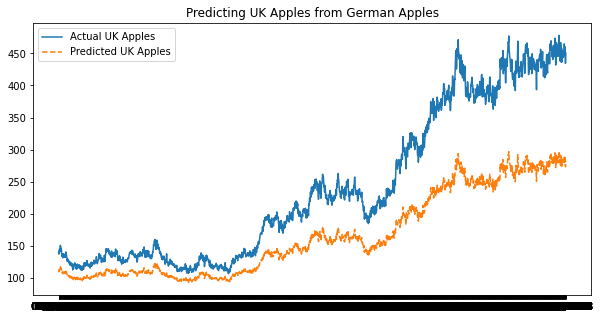

MSE: 8237.1400, R²: 0.4105


In [73]:
# Creating a predictor
# Using an Ordinary Least Squares (ULS) linear regression model

X = sm.add_constant(norm_data["UK Apples (EUR)"])
Y = norm_data["German Apples (EUR)"]

model = sm.OLS(Y, X, missing='drop').fit()
print(model.summary())

norm_data["UK Apples Prediction"] = model.predict(X)

# Plots

plt.figure(figsize=(10,5))
plt.plot(norm_data.index, norm_data["UK Apples (EUR)"], label="Actual UK Apples")
plt.plot(norm_data.index, norm_data["UK Apples Prediction"], label="Predicted UK Apples", linestyle="--")
plt.legend()
plt.title("Predicting UK Apples from German Apples")
plt.show()

# Error Metrics

from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(norm_data["UK Apples (EUR)"], norm_data["UK Apples Prediction"])
r2 = r2_score(norm_data["UK Apples (EUR)"], norm_data["UK Apples Prediction"])
print(f"MSE: {mse:.4f}, R²: {r2:.4f}")

# Trading Strategy

### Basis Trading Strategy (OU Mean-Reversion)

- **Define the basis**
  - Compute the spread between two related products (e.g., Product A – α·Product B, adjusted for FX if needed).
  - Ensure the basis is stationary and mean‑reverting.

- **Model the basis**
  - Fit an Ornstein–Uhlenbeck (OU) process (via AR(1) regression).
  - Estimate long‑term mean (μ), speed of reversion (θ), and volatility (σ).

- **Generate trading signals**
  - Calculate z‑score:  
    

$$z_t = \frac{B_t - \mu}{\sigma_{\text{stationary}}}$$


  - **Enter trades:**
    - Go **long spread** (buy underpriced, short overpriced) when \(z_t < -2\).
    - Go **short spread** when \(z_t > +2\).
  - **Exit trades:** Close when \(z_t\) reverts near 0 (e.g., |z| < 0.5).

- **Position sizing**
  - Use hedge ratio (α) from regression to size positions so the portfolio is dollar‑neutral.
  - Scale exposure by volatility or risk budget.

- **Risk management**
  - Stop‑loss if z‑score exceeds extreme threshold (e.g., |z| > 3).
  - Limit capital allocation per trade.
  - Monitor liquidity and transaction costs.

- **Performance monitoring**
  - Backtest strategy on historical data.
  - Track Sharpe ratio, drawdowns, and hit rate.
  - Re‑estimate OU parameters periodically to adapt to regime shifts.